# 从拉勾网数据，看西安的工作机会

## 数据来源
自己写爬虫程序，爬取了拉勾网在西安所有的招聘企业和职位。存在MongoDB数据库中。<br>
选择拉勾网是因为它的职位信息用JSON格式保存，省去了查找内容的麻烦。用MongoDB是想练习MongoDB的使用。<br>
在使用MongoDB之前，是将获得的信息保存为csv格式。使用csv保存信息在检查重复项时比较麻烦，需要先读取csv文件，然后再判断数据是否重复。但是用MongoDB，可以直接对数据库进行操作，节省了判断重复和写入csv的时间。

|字段|内容|
|----|----|
|positionId|职位ID|
|companyID|公司ID|
|positionName|职位名|
|workYear|工作经验|
|education|学历|
|jobNature|工作性质（全职\兼职）|
|createTime|创建时间|
|salary|薪酬|
|industryField|行业|
|financeStage|融资状态|
|companySize|公司规模|
|companyFullName|公司全名|
|firstType|职位一级分类|
|secondType|职位二级分类|
|district|区域|

## 分析目的
希望通过对所有招聘企业和职位的分析，获得：
* 企业的区域、规模、行业和融资情况分布；
* 职位的工作经验，学历，薪酬分布。

## 结论
1. 找工作，换工作首选高新区，机会最多；
2. 有1-3年工作经验，大专学历以上的机会最多，是跳槽的好时机；
3. 如果不介意初创型企业，满足结论2的可以尝试，毕竟机会多；
4. 懂销售的人，哪里都需要；
5. 从事技术开发的人，如果月薪达不到9000，赶紧考虑跳槽；
6. 在成熟型大企业，如果一个月工资不到8000，就已经拖了企业后腿。努力点，可以达到10000；
7. 硕士生如果跳槽，月薪往10000以上谈，否则都不好意思和人打招呼；
8. 年轻人好好工作，十年以后实现财务自由不是梦。

导入所需的库

In [1]:
import pandas as pd
import numpy as np
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from jupyterthemes import jtplot
jtplot.style(theme='grade3')

from pymongo import MongoClient
%pylab inline
plt.rcParams['font.sans-serif'] = ['SimHei'] # 步骤一（替换sans-serif字体）
plt.rcParams['axes.unicode_minus'] = False   # 步骤二（解决坐标轴负数的负号显示问题)

Populating the interactive namespace from numpy and matplotlib


连接到MongoDB。

In [26]:
client = MongoClient('mongodb://127.0.0.1/lagou')
db = client.lagou
collection = db.dataset

# 直接从MongoDB读取数据，并且删除“_id”。
df = pd.DataFrame(list(collection.find()))
df.drop(['_id'], inplace = True, axis=1)

In [27]:
display(df.head(2))
display(df.shape)

,adWord,appShow,approve,businessZones,city,companyFullName,companyId,companyLabelList,companyLogo,companyShortName,...,positionAdvantage,positionId,positionLables,positionName,promotionScoreExplain,publisherId,salary,score,secondType,workYear
0,0,0,1,"[文景路, 张家堡]",西安,广州市有车以后信息科技有限公司,54727,"[股票期权, 带薪年假, 年度旅游, 弹性工作]",i/image2/M00/1D/C4/CgoB5loJkmeAP1BTAADr8BrnE1g...,有车以后,...,C轮、大平台、高成长、高提成,3556706,"[汽车, 媒体, 商务拓展]",客户经理,None,4862291,4k-8k,0,商务拓展/BD,1-3年
1,0,0,1,None,西安,西安小喵信息科技有限公司,146956,"[股票期权, 五险一金, 年底双薪, 专项奖金]",i/image/M00/60/C7/CgqKkVf6HzSAL04AAAAns-vAQ2w8...,小喵科技,...,"五险一金,股票期权,午餐补助,BAT背景",2695016,"[硬件开发, 模具设计]",高级结构工程师,None,6048989,8k-15k,0,硬件开发,3-5年


(3193, 39)

一共采集到3193条数据，也就是说有3193个职位。检查缺失项。

In [28]:
df.apply(lambda x: sum(x.isnull()))

adWord                      0
appShow                     0
approve                     0
businessZones            1644
city                        0
companyFullName             0
companyId                   0
companyLabelList            0
companyLogo                 6
companyShortName            0
companySize                64
createTime                  0
deliver                     0
district                   32
education                   0
explain                  3193
financeStage               73
firstType                   0
formatCreateTime            0
gradeDescription         3193
imState                     0
industryField              68
industryLables              0
isSchoolJob                 0
jobNature                   0
job_bt                      0
lastLogin                   0
pcShow                      0
plus                     3193
positionAdvantage           1
positionId                  0
positionLables              0
positionName                0
promotionS

有一些列数据全部缺失，从名称上也看不出有什么意思，需要全部删除。<br>
有一些列存在部分缺失数据，可能是招聘企业在填写公司或职位介绍的时候忽略没有填写。这部分数据在后面分析时，根据需要再决定是否删除。

In [29]:
miss_cols = [x for x in df.columns if sum(df[x].isnull()) == 3193]
df.drop(miss_cols, axis=1, inplace=True)

In [30]:
index = pd.MultiIndex.from_arrays([df['companyId'], df['positionId']])

In [ ]:
pd.DataFrame(df, index_col=index)

In [9]:
def fillnull(x):
    if x == '':
        return '其他'
    elif x == '高新技术产业开发区':
        return '高新区'
    elif x == '经济技术开发区':
        return '经开区'
    elif x == '西安国家民用航天产业基地':
        return '航天基地'
    elif x == '阎良国家航空高新技术产业基地':
        return '阎良区'
    else:
        return x
df = df.applymap(lambda x: fillnull(x))

因为同一公司会招聘多个职位，因此公司在数据集中会有重复，为了进行公司维度的分析，需要删除重复项。

In [10]:
df['count'] = 1
company_df = df.drop_duplicates('companyID')
position_df = df.drop_duplicates('positionId')
len(company_df),len(position_df)
#company_df.to_csv('company.csv')
#position_df.to_csv('position.csv')

(1582, 5622)

一共是1582家公司，招聘5622个职位。

## 公司维度的分析

C:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


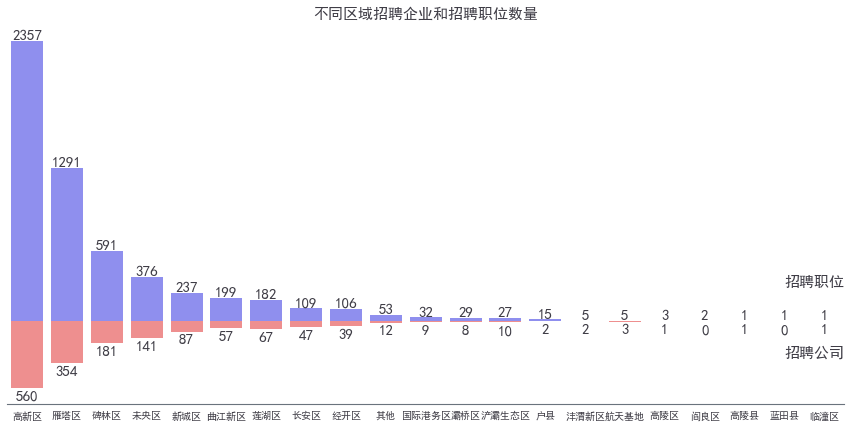

In [11]:
district_count = company_df.groupby('district')['count'].sum().sort_values(ascending=False)
position_count = position_df.groupby('district')['count'].sum().sort_values(ascending=False)
fig =  plt.figure(figsize=(15,7))
sns.barplot(x=list(position_count.index),y=position_count,color='blue',alpha=0.5)
district_count['阎良区'] = 0
district_count['蓝田县'] = 0
district_count = district_count.reindex(list(position_count.index))
sns.barplot(x=list(district_count.index),y=-district_count,color='red',alpha=0.5)
plt.xticks(range(len(position_count)),list(position_count.index),rotation=0,fontsize=10)
sns.despine(left=True)
for x, y,z in zip(range(len(position_count)), position_count,district_count):
    plt.text(x, y+15, '%d'%y, ha='center', fontsize=15)
    plt.text(x, -z-100, '%d'%(z), ha='center', fontsize=15)
    
plt.text(len(position_count)-2,300,'招聘职位', fontsize=15)
plt.text(len(position_count)-2,-300,'招聘公司', fontsize=15)
plt.ylim([-700,2500])
plt.title('不同区域招聘企业和招聘职位数量',fontsize=15)
plt.legend()
frame = plt.gca()
frame.axes.get_yaxis().set_visible(False)

蓝色表示每个区域招聘的职位数量，红色表示招聘的公司数量。<br>
因为职位是按照工作地点划分，所有阎良没有公司招聘，但是有两个职位。蓝田没有公司招聘，但是有一个职位。<br>

从上面的图可以看出，<font color='red'>高新，雁塔和碑林无论在招聘公司数量还是招聘职位数量上都是前三甲，但是三者之间的差距比较大，两两之间差了一倍</font>。<br>
需要注意的是，高新区不是一个行政区域，它是在雁塔区内，因此有些标注雁塔区的公司或者职位，也属于高新区，因此高新区的公司和数量可能会更高。

对比西安统计局发布的2016年各区县GDP指标，可以得出，招聘热度与GDP成正比。

在公司所从事的行业上，每个公司最多可以选两个，需要对行业创建哑变量。

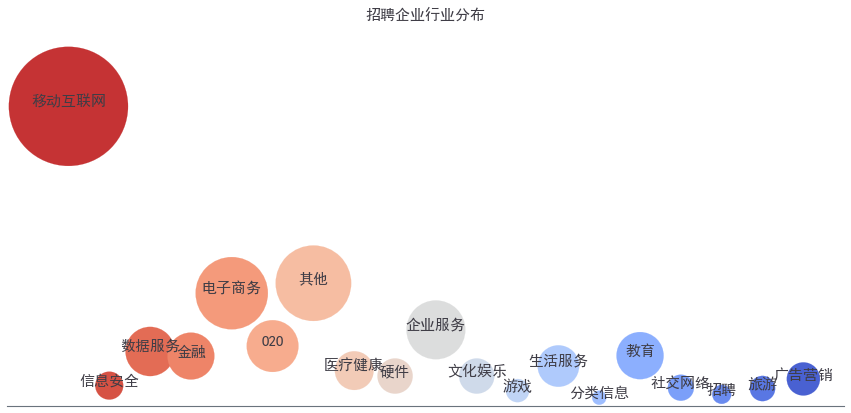

In [12]:
import re

###从数据集中抽取所有的行业###
#因为公司从事行业的标签不规整，有的以‘，’分隔，有的以‘、’分隔，有的存在空格，
#需要用正则表达式进行分隔处理
industryField = []
for x in company_df['industryField']:
    field = str(x).strip()
    temp = re.split(',|、',field)
    for y in temp:
        if str(y).strip() not in industryField:
            industryField.append(y)

            
#在行业中，有‘不限’和‘其他’两种情况，可以合并，删除‘不限’
industryField.remove('不限')


#生成一个包含所有领域的DataFrame
dummies = pd.DataFrame(np.zeros((len(company_df), len(industryField))),
                    columns=industryField,
                    index=list(company_df.index))

#在dummies中，将公司所从事的行业设为1
for i, field in zip(list(company_df.index),company_df['industryField']):
    field.replace('不限', '其他')
    temp = re.split(',|、|\s',str(field))
    if '' in temp:
        temp.remove('')
    try:
        dummies.loc[i, temp] = 1
    except KeyError:
        continue

dummies_count = dummies.apply(lambda x:sum(x))#.sort_values(ascending=False)
fig =  plt.figure(figsize=(15,7))
plt.scatter(x=range(len(dummies_count.index)),y=dummies_count+dummies_count/20,
            s=dummies_count*20, c=sns.color_palette("coolwarm_r",len(dummies_count.index)))
plt.ylim([-10,950])
plt.xlim([-1.5,19])

for x, y,z in zip(range(len(dummies_count.index)),dummies_count+dummies_count/20,list(dummies_count.index)):
    plt.text(x,y,'%s'%z,ha='center',fontsize=15)
sns.despine(left=True)
plt.title('招聘企业行业分布',fontsize=15)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)

在所有招聘的公司中，<font color='red'>从事移动互联网领域的最多，其次是其他，第三是电子商务</font>。<br>
从事数据服务的公司接近100家，这个可以研究一下。但是“其他”排第二就有点匪夷所思，难道这些公司都是从事多元化服务的集团公司，无法确定从事某一具体行业？

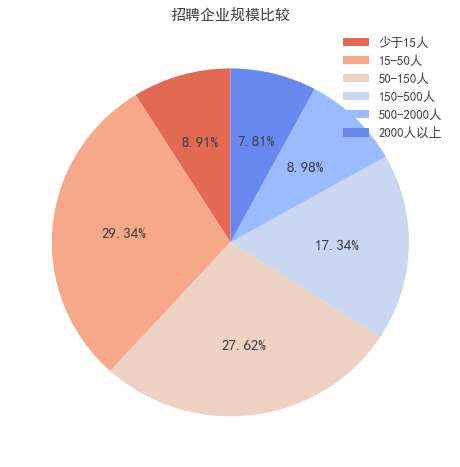

In [13]:
sns.set_palette('coolwarm_r')
count_num = company_df['companySize']\
            .value_counts()\
            .reindex(['少于15人','15-50人','50-150人','150-500人',
                      '500-2000人','2000人以上'])
count_num.plot(kind='pie', autopct='%.2f%%',startangle=90,
                  labels=['']*7,
                  figsize=(8,8), fontsize=15)
plt.legend(['少于15人','15-50人','50-150人','150-500人','500-2000人','2000人以上'],loc='best')
plt.ylabel('')
plt.title('招聘企业规模比较',fontsize=15)

观察上面的饼图，如果不考虑人数少于15人的公司，<font color='red'>公司规模越大，数量越少。西安地区的企业看起来像一个金字塔结构，中小企业占大多数</font>。

In [14]:
fig = plt.figure(figsize=(15,5))
sns.countplot(x='financeStage', data=company_df, order=stage_list, palette="coolwarm_r")

NameError: name 'stage_list' is not defined

In [ ]:
stage_list = ['初创型(不需要融资)','初创型(未融资)','初创型(天使轮)',
              '成长型(不需要融资)','成长型(A轮)', '成长型(B轮)',
              '成熟型(不需要融资)','成熟型(C轮)', '成熟型(D轮及以上)',
              '上市公司', '其他']

fig = plt.figure(figsize=(15,5))
sns.countplot(x='financeStage', data=company_df, order=stage_list, palette="coolwarm_r")

sns.despine(top=True)
plt.ylabel('')
plt.title('招聘企业发展阶段分布',fontsize=15)

从公司的融资阶段来看，和公司规模的分布大致相同，初创型企业最多，特别是未融资的初创企业。排名第二的是成长型不需要融资的企业。从拉勾的企业发展阶段涵盖了企业发展的所有阶段，真是不明白这些其他是属于那个阶段。

## 职位维度的分析
<br>
### 职位对学历的要求

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,6.9))
education_order = ['应届毕业生','1年以下','1-3年',
                     '3-5年','5-10年','10年以上','不限']
sns.countplot(x='workYear',data=position_df,\
              ax=ax[0],palette='coolwarm_r',\
              order=education_order)

sns.despine(left=True)
ax[0].set_xlabel('')
ax[0].set_ylabel('')
ax[0].set_title('工作经验要求',fontsize=12)
position_df['education'].value_counts()\
                        .plot(kind='pie', autopct='%.2f%%',
                              startangle=90,labeldistance=1.1,
                              ax=ax[1],fontsize=12,legend=False,labels=['']*7)
plt.legend(list(position_df['education'].value_counts().index))
ax[1].set_xlabel('')
ax[1].set_ylabel('')
ax[1].set_title('学历要求',fontsize=12)

In [ ]:
fig = plt.figure(figsize=(15,5))
sns.countplot(x='financeStage',data=position_df,hue='workYear',palette='coolwarm_r',order=stage_list)
plt.legend(loc='upper right')
sns.despine(top=True)
plt.xlabel('')
plt.ylabel('')
plt.title('不同阶段企业对工作经验的要求',fontsize=15)

在招职位中，对学历的要求似乎不太高，大专占大多数，极少职位要求硕士。有些职位甚至更开明，对学历没有要求，只要“<font color='ff0000'>有能力，有激情</font>”就行。<br>
有1-3年工作经验的本科生需求最大。在外地工作，有一定经验的人可以考虑回西安。

### 不同职位的人力需求

In [ ]:
def position_item(x):
    if x == '市场与销售':
        x = '市场/商务/销售类'
    elif x == '金融':
        x = '金融类'
    elif x == '设计':
        x = '设计类'
    elif x == '产品':
        x = '产品/需求/项目类'
    elif x == '职能':
        x = '综合职能类'
    elif x == '运营':
        x = '运营/编辑/客服'
    elif x == '其它':
        x = '其他'
    
    return x
   

position_df['firstType'] = position_df['firstType'].map(lambda x:position_item(x))

fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15,10))

position_df['firstType'].value_counts(ascending=True).plot(kind='barh',fontsize=15,title='职位一级分类',
                                             alpha=0.7, ax=ax[0])

position_df['secondType'].value_counts()\
                         .head(20)\
                         .sort_values(ascending=True)\
                         .plot(kind='barh',fontsize=15,title='职位二级分类',alpha=0.7, ax=ax[1])
sns.despine(left=True)


因为职位的二级分类比较多，只取招聘最多的前20个分类。<br>
拉勾网的宣传是专注互联网工作机会。一直以为互联网企业的技术类职位需求应该是最多的。在分析后才发现其实不是，市场/商务/销售类的招聘需求最多，其次才是开发/测试/运维类，第三是运营/编辑/客服。而在二级分类中，销售远远高于排名第二的后端开发。

## 薪酬的分布

薪酬大多是一个范围，取平均值。有的薪酬是用“xxx+”或“xxx以上”，取最小值。

In [ ]:
def replace_salary(x):

    temp_salary = re.split('-',x)
    
    temp_salary[0] = str(temp_salary[0]).replace('以上','')
    temp_salary[0] = str(temp_salary[0]).replace('+','')
    
    temp_salary[0] = float(re.sub('[kK]', '000', temp_salary[0]))
    
    if len(temp_salary)==1:
        return temp_salary[0]
    else:
        temp_salary[1] = float(re.sub('[kK]', '000', temp_salary[1]))
        return (temp_salary[0]+temp_salary[1])/2

position_df['salary'] = position_df['salary'].map(lambda x:replace_salary(x))

### 薪酬整体分布

In [ ]:
#fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(15,7))
fig = plt.figure(figsize=(15,7))
plt.subplot2grid((1,3),(0,0))
sns.boxplot(y='salary',data=position_df,showfliers=False)
plt.title('整体薪酬箱形图')
plt.subplot2grid((1,3),(0,1),colspan=2)
sns.distplot(position_df['salary'],kde=False,bins=100)
plt.title('整体薪酬直方图')

在薪酬的整体分布上，4000-5000分布是最多的，其次是6000-7000和7000-8000。<br>
月薪的中位数是6000，如果月薪达到6000，就超过了一半的人，能达到9000，就超过了75%的人。

### 薪酬与职位的关系

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
position_df.loc[position_df['jobNature']=='全职',:]\
           .groupby('firstType')['salary']\
           .median()\
           .sort_values(ascending=True)\
           .plot(kind='barh',fontsize=15,alpha=0.7,ax=ax[0],title='一级职位的薪酬中位数')
position_df.loc[position_df['jobNature']=='全职',:]\
           .groupby('secondType')['salary']\
           .median()\
           .sort_values(ascending=False).head(10).sort_values(ascending=True)\
           .plot(kind='barh',fontsize=15,alpha=0.7,ax=ax[1],title='二级职位的薪酬中位数')
plt.subplots_adjust(wspace=0.5)
ax[0].set_ylabel('')
ax[1].set_ylabel('')
sns.despine(left=True)

有一技傍身还是好的。技术类岗位的薪酬最高，超过一半的技术类岗位薪酬超过9000，而在其中的高端技术职位更是超过12000。<br>

### 不同发展阶段企业的薪酬

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,8))

sns.pointplot(x='financeStage', y='salary', data=position_df.loc[position_df['jobNature']=='全职',:],
              estimator=np.median,errwidth=0,order=stage_list,ax=ax[0])
#plt.title('不同阶段企业的薪酬中位数',fontsize=15)
sns.despine(top=True)
ax[0].set_xlabel('')
ax[0].set_ylabel('')
ax[0].set_title('不同阶段企业的薪酬中位数',fontsize=12)

sns.pointplot(x='companySize',y='salary',data=position_df.loc[position_df['jobNature']=='全职',:],
              estimator=np.median,errwidth=0,
              order=['少于15人','15-50人','50-150人','150-500人','500-2000人','2000人以上'],ax=ax[1])
#plt.title('不同规模企业的薪酬中位数',fontsize=15)
sns.despine(top=True)
ax[1].set_xlabel('')
ax[1].set_ylabel('')
ax[1].set_title('不同规模企业的薪酬中位数',fontsize=12)

成熟型企业的薪酬普遍高于初创型和成长型企业。如果希望钱多，还是要找成熟型企业。但是对比工作经验和学历的要求，这类企业的要求也相对较高，普遍要求3-5年工作经验。

### 工作经验与薪酬的关系

In [ ]:
fig = plt.figure(figsize=(15,5))
sns.pointplot(x='workYear',y='salary',data=position_df.loc[position_df['jobNature']=='全职',:],
            errwidth=0,order=['应届毕业生','1年以下','1-3年','3-5年','5-10年','10年以上','不限'],
            estimator=np.median,color='blue',linestyles='--')

sns.barplot(x='workYear',y='salary',hue='education',data=position_df.loc[position_df['jobNature']=='全职',:],
            errwidth=0,order=['应届毕业生','1年以下','1-3年','3-5年','5-10年','10年以上','不限'],
            estimator=np.median, hue_order=['不限','大专','本科','硕士'])
#g = sns.FacetGrid(position_df.loc[position_df['jobNature']=='全职',:], col='workYear', col_wrap=4,
#                  col_order=['应届毕业生','1年以下','1-3年','3-5年','5-10年','10年以上','不限'])
#g = (g.map(sns.pointplot, 'education','salary',estimator=np.median, errwidth=0,
#          order=['不限','大专','本科','硕士']).set_axis_labels('',''))
plt.title('不同工作经验的薪酬中位数',fontsize=15)
sns.despine(top=True)
plt.xlabel('')
plt.ylabel('') 

上面的柱状图显示了每种工作经验要求中不同学历的薪酬中位数，折线图展现的是不同工作经验要求对应的薪酬中位数。
薪酬高低是高工作经验累计的。5年以上工作经验的能达到10000以上，10年以上更是达到20000。<br>
招聘硕士研究生的公司少，但是硕士研究生一旦找到工作就是高薪。但是在10年以上的经验要求中，本科的薪酬高于硕士，估计差距产生的原因是因为公司不同。

## 结论
1. 找工作，换工作首选高新区，机会最多；
2. 有1-3年工作经验，大专学历以上的机会最多，是跳槽的好时机；
3. 如果不介意初创型企业，满足结论2的可以尝试，毕竟机会多；
4. 懂销售的人，哪里都需要；
5. 从事技术开发的人，如果月薪达不到9000，赶紧考虑跳槽；
6. 在成熟型大企业，如果一个月工资不到8000，就已经拖了企业后腿。努力点，可以达到10000；
7. 硕士生如果跳槽，月薪往10000以上谈，否则都不好意思和人打招呼；
8. 年轻人好好工作，十年以后实现财务自由不是梦。